# Cleaning anomalies in time series per region slug



## Load  libraries

In [3]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

#from copy import deepcopy
#import numpy as np
#import pandas as pd
#pd.options.display.max_columns = 999
#import yaml
#import matplotlib.pyplot as plt 
#from datetime import datetime
#
#import warnings
#warnings.filterwarnings('ignore')
#
# Plotting
import plotly
import plotly.graph_objs as go
import cufflinks as cf
plotly.offline.init_notebook_mode(connected=True)

def iplottitle(title, width=40):
    return '<br>'.join(textwrap.wrap(title, width))
#import seaborn as sns
#import matplotlib.pyplot as plt
#sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
#
#import plotnine as p9
#from mizani.breaks import date_breaks
#from mizani.formatters import date_format
#p9.theme_set(p9.theme_linedraw()) # default theme
#
## Setting cufflinks
#import textwrap
#import cufflinks as cf
#cf.go_offline()
#cf.set_config_file(offline=False, world_readable=True)
#import yaml
#from jinja2 import Template
#cf.themes.THEMES['custom'] = yaml.load(open('cufflinks_template.yaml', 'r'))
#
## Manipulation 
#from siuba import *
#
## Outliers
#from adtk.data import validate_series
#from adtk.transformer import DoubleRollingAggregate
#from adtk.visualization import plot
#from adtk.pipe import Pipeline
#from adtk.detector import QuantileAD
#from adtk.transformer import ClassicSeasonalDecomposition

## Load data

### dahsboard data

## Process creation

In [4]:

from pathlib import Path
import numpy as np
import pandas as pd
from functools import reduce
from loguru import logger
from datetime import datetime, timedelta
from siuba import *

# plots
import matplotlib.pyplot as plt 
import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format
p9.theme_set(p9.theme_linedraw()) # default theme

from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import LevelShiftAD, PersistAD, GeneralizedESDTestAD, SeasonalAD, AutoregressionAD
from tsmoothie.smoother import DecomposeSmoother

from src import utils
conn = utils.connect_athena(path='../configs/athena.yaml')


../src/utils.py:158: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


### Functions

#### init functions

In [5]:
# Initialize functions

def _validate_series(df, column_name):
    """
    A function to validate series
    
    Parameters
        ----------
        df : data frame 
            Data frame with column to validare. The data frame requires
            columns region_slug and date to be sorted. Date is defined as
            the index.
        column_name : str
            Name of the column to validate
    """

    logger.debug(f"... validating {column_name}...\n")
    y_df = df.sort_values(['date'])[['date', column_name]].set_index('date')
    s = validate_series(y_df)
    
    return s

#### Anomalies functions

In [6]:
### Outlier functions
def _outlier_persist_ad(s, target_column_name, c_param = 3.0, window_param = 7):
    
    try :
        persist_ad = PersistAD(c=c_param, side='both', window = window_param)
        anomalies = persist_ad.fit_detect(s)
    except : 
        logger.debug('!! No Persist !!')
        anomalies = s
        anomalies[target_column_name] = 0
    finally : 
        anomalies = anomalies \
            .rename(columns={target_column_name:'anomaly_persist'}) \
            .reset_index()   
    
    return anomalies

def _outlier_gesdt_ad(s, target_column_name, alpha_param = 0.3, window_param = 7):
    
    try :
        esd_ad = GeneralizedESDTestAD(alpha=alpha_param)
        anomalies = persist_ad.fit_detect(s)
    except : 
        logger.debug('!! No gesdt !!')
        anomalies = s 
        anomalies[target_column_name] = 0
    finally : 
        anomalies = anomalies \
            .rename(columns={target_column_name:'anomaly_gesdt'}) \
            .reset_index()   
    
    return anomalies

def _outlier_seasonal_ad(s, target_column_name, c_param = 3.0):
    
    try : 
        seasonal_ad = SeasonalAD(c=c_param, side="both")
        anomalies = seasonal_ad.fit_detect(s)
    except : 
        logger.debug('!! No Seasonal !!')
        anomalies = s
        anomalies[target_column_name] = False
    finally : 
        anomalies = anomalies \
            .rename(columns={target_column_name:'anomaly_seasonal'}) \
            .reset_index()   
        
    return anomalies     

def _outlier_autregr_ad(s, target_column_name, c_param = 3.0, n_steps_param = 1, step_size_param=7):
    
    try : 
        autoregression_ad = AutoregressionAD(n_steps=n_steps_param, step_size=step_size_param, c=c_param)
        anomalies = autoregression_ad.fit_detect(s)
    except : 
        logger.debug('!! No Seasonal !!')
        anomalies = s    
        anomalies[target_column_name] = 0
    finally : 
        anomalies = anomalies \
            .rename(columns={target_column_name:'anomaly_autor'}) \
            .reset_index()   
        
    return anomalies     

def _anomalies_detector(s, target_column_name):
    """
    The function runs three algorithms to detect outliers.
    
    Parameters
        ----------
        s : data frame 
            Description
        target_column_name : str
            Target column name to detect outliers
    """
    
    anomalies = _outlier_persist_ad(s, target_column_name) \
        .merge(_outlier_seasonal_ad(s, target_column_name)) \
        .merge(_outlier_autregr_ad(s, target_column_name)) \
        .fillna(0)
    
    anomalies['anomaly_sum'] = \
        (anomalies['anomaly_persist']) + \
        (anomalies['anomaly_seasonal'] == True) +  \
        (anomalies['anomaly_autor'])
    anomalies.head(2)
      
    return(anomalies[anomalies.anomaly_sum > 0])


# 2. Find anomalies
def _find_anomalies(df, anomaly_vote_minimun, target_column_name, print_report=True):

    logger.debug("\n... finding outliers ...")
    
    # validate series
    s = _validate_series(df, target_column_name)
    #plot(s)
    
    # join anomialies detector
    df_anomaly = df.merge(_anomalies_detector(s, target_column_name), how = 'left')
    anomalies_cnt = sum(df_anomaly.anomaly_sum >= anomaly_vote_minimun)
    anomalies_date = df_anomaly[df_anomaly.anomaly_sum >= anomaly_vote_minimun].date.to_list()
    
    logger.debug('Number of anomalies found: ' + str(anomalies_cnt))  
    logger.debug(anomalies_date)
    
    if print_report:
        logger.debug('... printing anomalies report ...\n')
        print(_plot_anomalies(df_anomaly, 
                              observed_column = target_column_name,
                              anomalies_cnt=anomalies_cnt))
    
    return(df_anomaly, anomalies_date)


#### Imputation functions

In [36]:
### Imputation functions
def _decompose_lowess(variable_smooth, missing_values, smooth_fraction):
    # operate smoothing
    smoother = DecomposeSmoother(smooth_type='lowess', 
                                 periods=7,
                                 smooth_fraction=smooth_fraction)
    smoother.smooth(variable_smooth)

    result = variable_smooth
    smooth_result = smoother.smooth_data[0]
    result[missing_values] = smooth_result[missing_values]
    
    return result

# 3. Impute anomalies
def _impute_anomalies(observed_column, 
                      date_column,
                      anomaly_sum_column, 
                      anomaly_vote_minimun, 
                      smooth_fraction = 0.4):
    """
    The function runs several algorithms to detect level shifts.
    
    Parameters
        ----------
        observed_column : data frame 
            Description
        date_column : str
            Description
        nomaly_sum_column : str
            Description
        anomaly_vote_minimun : str
            Description
        smooth_fraction : str
            Description
    """
    
    logger.debug("\n... imputing outliers ...")
    
    # building data frame to impute
    df_impute = pd.DataFrame({
        'date': date_column,
        'observed_column': observed_column,
        'anomaly_sum': anomaly_sum_column,
        'observed_missing': observed_column
    }) 
    # create missing values
    df_impute.loc[df_impute.anomaly_sum >= anomaly_vote_minimun, 'observed_missing'] = None
    df_impute.loc[df_impute.observed_column < 0, 'observed_missing'] = None

    df_impute = df_impute.set_index('date')
    
    # algorithms to impute
    df_impute =  df_impute \
        .assign(RollingMean=df_impute.observed_missing \
                    .fillna(df_impute.observed_missing \
                            .rolling(30, min_periods=1,) \
                            .mean()) ) \
        .assign(RollingMedian=df_impute.observed_missing \
                    .fillna(df_impute.observed_missing \
                            .rolling(30, min_periods=1,) \
                            .median()) ) \
        .assign(Polinomial=df_impute.observed_missing \
                    .interpolate(method='polynomial', order = 5)) \
        .assign(Loess=_decompose_lowess(df_impute.observed_column, 
                                        df_impute.observed_missing.isna(),
                                        smooth_fraction = smooth_fraction)) 


    return df_impute


#### Shift functions

In [33]:
### Shift functions

def _c_param(region_slug, 
             athena_path = '/home/soniame/shared/spd-sdv-omitnik-waze/corona'):
    
    c_region = pd.read_csv(athena_path + '/raw/cities_c_iqr.csv') \
        .rename(columns={'city':'region_slug'})
    
    
    if region_slug in c_region.region_slug:
        c_param = c_region[c_region.region_slug == region_slug].c_low_p1.to_list()[0]
    else :
        c_param = 3
        
    logger.debug('c_param: ' + str(c_param))
    return c_param

def _level_shift_detection(s, c_param = 6.0, window_param = 14, print_plot = False):
    """
    Level shift or change point detection. This function uses the function 
    LevelShiftAD from ADTK library.
    
    Parameters
    ----------
        s : validated serie object 
            Description
        c_param : dbl, default 6.0
            Description
        window_param : int, default 14
            Description
        print_plot: bool, default True
            Description
    """
    #logger.debug(f"... detecting shift c{c_param}-w{window_param}...")
    level_shift_ad = LevelShiftAD(c=c_param, side='both', window=window_param)
    shifts = level_shift_ad.fit_detect(s)
    
    if print_plot:
        plot(s, anomaly=shifts, anomaly_color='red')
    
    return shifts


def _run_shift_grid(s, observed_variable, c_param, low_grid = .20, upp_grid = .60):
    """
    Run shift detector grid for several values. 
    
    Parameters
    ----------
        s : validated serie object 
            Description
        observed_variable : validated serie object 
            Description    
        c_param : dbl, default 6.0
            Description
        low_grid : int, default 14
            Description
        upp_grid: bool, default True
            Description
    """
    logger.debug(f"\n... shift level running grid  ...")
    
    shift_l = list()
    for cp in [round(c_param-c_param*(upp_grid), 4), 
               round(c_param-c_param*(low_grid), 4), 
               c_param, 
               round(c_param+c_param*(low_grid), 4), 
               round(c_param+c_param*(upp_grid), 4) ]:
        for wdw in [14, 15, 16, 17, 18]:    
            shift = _level_shift_detection(s, c_param = cp,
                                           window_param=wdw, 
                                           print_plot = False) \
                    .rename(columns={observed_variable:f'shift_c{cp}_w{wdw}'})
            shift_l.append(shift)
    len(shift_l)    
    df_grid = reduce(lambda df1, df2: df1.merge(df2, on='date'), shift_l)
    df_grid.shape
    
    logger.debug(f"Total combinations: {len(shift_l)}")
    
    return df_grid

def _shifted_adtk_ts(s, column_name, agg="std", window=(3,3), diff="l2", print_plot=True):
    # shift ts level
    
    s_transformed = DoubleRollingAggregate(
        agg=agg,
        window=window,
        diff=diff).transform(s).rename(columns={column_name:'adtk_shift'})
    
    if print_plot:
        plot(pd.concat([s, s_transformed], axis=1))
        
    return s_transformed


def _shift_sum(df_shift):
    df_shift_sum = (df_shift.reset_index()
     >> filter(_.date > '2020-03-31',
              ((_.date < '2020-12-15') | (_.date > '2021-01-15')))
     >> gather('variable', 'value', -_.date)
     >> filter(_.variable.str.startswith('shift'))
     >> group_by('date')
     >> summarize(shift_sum = _.value.sum())
     >> filter(_.shift_sum > 0)
     >> arrange('date')
    )

    return df_shift_sum

def _rolling_manual_sum(tab, days_before= 0, days_after = 7):
    rolling_sum = list()
    for dat in tab.date:
        date_init = dat + timedelta(days=days_before)
        date_end  = dat + timedelta(days=days_after)
        #logger.debug( str(dat ) + ' to ' + str(dat + timedelta(days=7)))
        sum_sum = tab[(tab.date >= date_init) & (tab.date < date_end)].suma.sum()
        rolling_sum.append(sum_sum)

    return rolling_sum

def _shift_window_sum(df_shift, days_before= 0, days_after = 7):
    tab = (df_shift.reset_index()
     >> filter(_.date > '2020-03-31', 
              ((_.date < '2020-12-15') | (_.date > '2021-01-15')))
     >> gather('variable', 'value', -_.date)
     >> filter(_.variable.str.startswith('shift'))
     >> arrange(_.date)
     >> group_by('date')
     >> summarize(suma = _.value.sum())
     >> ungroup()
    )
    tab['shift_sum'] = _rolling_manual_sum(tab, 
                                             days_before= days_before, 
                                             days_after = days_after)
    
    return tab[['date', 'shift_sum']]

def _initial_shift_date(df_shift_sum):

    shift_init = df_shift_sum[df_shift_sum.shift_sum == df_shift_sum.shift_sum.max()].date.min()
    
    logger.debug(f'Shift found at {shift_init}')
    
    return shift_init


def _shift_ts(shift_init, date_column, to_shift_column):
    
    # TODO: step_shift_before, step_shift_after
    # a two weeks both sided window
    shift_wdw_init = shift_init - timedelta(days=7)
    shift_wdw_end  = shift_init + timedelta(days=7)
    # level centered
    center_point = ((to_shift_column[(date_column >  shift_wdw_init) & 
                        (date_column <= shift_init)].mean()) -
                    (to_shift_column[(date_column >  shift_init) & 
                        (date_column <= shift_wdw_end)].mean())
                   )
    # change print to logger
    logger.debug('\n')  
    logger.debug('Center point: ' + str(center_point))
    
    shifted_column = to_shift_column
    shifted_column[ (date_column > shift_init) ] = \
        ( (to_shift_column[(date_column > shift_init)]) + center_point )
        
    return shifted_column   


def _shift_level_report(df_shift, df_shift_sum, observed_column, region_slug):
    
    df_shift=df_shift.reset_index()    
    df_shift['observed_column'] = observed_column
    df_gather = (df_shift
         >> gather('variable', 'value', -_['date', 'observed_column']) 
       )   
    tab = (df_gather
         >> mutate(value_rec = _.value.replace( 0, np.nan))
        )
    tab[['shift', 'cparam', 'window']] = tab['variable'].str.split('_',expand=True)
    gg_1 = (p9.ggplot(tab, p9.aes(x ='date', y = 'observed_column'))
     + p9.geom_line(size = 1) 
     + p9.geom_point(p9.aes(size = 'value_rec', color = 'value_rec')) 
     + p9.facet_grid('window ~ cparam')
     + p9.scale_size_continuous(range=(1.5, 1.5)) 
     + p9.theme(axis_text_x=p9.element_text(angle=90),
                figure_size=(8, 6) )
        )
    print(gg_1)
    
    gg_2 = (p9.ggplot(df_shift_sum, p9.aes(x ='date', y = 'shift_sum'))
     + p9.geom_col()
     + p9.theme(axis_text_x=p9.element_text(angle=90),
                figure_size=(8, 2) )
        )
    print(gg_2)
    
    #logger.debug(df_shift_sum[df_shift_sum.shift_sum == df_shift_sum.shift_sum.max()])
    

def _shift_level(df, 
                 column_name, 
                 c_param  = 3.0, 
                 low_grid = .20, 
                 upp_grid = .60, 
                 grid_days_before= 0, 
                 grid_days_after = 7,
                 print_report = False):

    logger.debug('\n')  
    logger.debug(f"... shifting levels for {column_name} ...")
    
    s = _validate_series(df.reset_index(), column_name=column_name)
    #plot(s)
    
    # running grid
    df_grid = _run_shift_grid(s, 
                            observed_variable = column_name,
                            c_param  = c_param, 
                            low_grid = low_grid, 
                            upp_grid = upp_grid)
    # grid summary
    df_grid_sum = _shift_sum(df_grid)
    #df_grid_sum = _shift_window_sum(df_grid, 
    #                                days_before= grid_days_before, 
    #                                days_after = grid_days_after)
    
    # first date
    shift_init  = _initial_shift_date(df_grid_sum)
    
    # center shift ts
    shifted_column = _shift_ts(shift_init  = shift_init,
                               date_column = df.date,
                               to_shift_column = df[column_name])
    
    
    if print_report:
        _shift_level_report(df_grid, 
                            df_grid_sum,
                            observed_column=s.reset_index()[column_name])
    
    return shifted_column, shift_init


#### Plot functions

In [17]:
### Plot functions
def _plot_levelshift(df_level, observed_column, shifted_column):
    print(observed_column)
    gg = (p9.ggplot(data=df_level,
               mapping=p9.aes(x='date', y=observed_column)) 
        + p9.geom_line(size = 1) 
        + p9.geom_line(p9.aes(y = shifted_column), size = 1, color = "red") 
        + p9.labs(title='Level Shift')
         )
    return gg
    
def _plot_anomalies(df_anomaly, observed_column, anomalies_cnt):
    gg = (p9.ggplot(data=df_anomaly,
               mapping=p9.aes(x='date', y=observed_column)) 
        + p9.geom_line(size = 1) 
        + p9.geom_point(p9.aes(size = 'anomaly_sum', color ='anomaly_sum') )
        + p9.labs(title='Anomalies identification',
                 subtitle = f'Anomalies found: {anomalies_cnt}') 
        + p9.theme(figure_size=(6, 3))
         )
    return gg
    
def _plot_imputation(df_imputate):
    gg = (p9.ggplot(data=df_imputate.reset_index(),
           mapping=p9.aes(x='date', y='observed_column')) 
        + p9.geom_line(color = 'gray') 
        + p9.geom_line(p9.aes(y = 'RollingMean'), color = "red", alpha = .4) 
        + p9.geom_line(p9.aes(y = 'Polinomial'), color = "green", alpha = .4) 
        + p9.geom_line(p9.aes(y = 'RollingMedian'), color = "blue", alpha = .4)
        + p9.geom_line(p9.aes(y = 'Loess'), color = "black") 
        + p9.labs(title='Imputation of anomalies')
        + p9.theme(figure_size=(6, 3))
         )    
    return gg

def _plot_end(df_run_1, df_run_2, df_end, region_slug):
        
        title_lab = f'{region_slug} \n ' +\
            f'Imputated dates: {df_run_1.outliers.sum() + df_run_2.outliers.sum()} \n' +\
            f'Level shifts dates: {df_run_1.level_shifts.sum() + df_run_2.level_shifts.sum()}'
        
        gg = (df_end 
            >> gather('variable', 'value', -_['date', 'region_slug', 'observed', 'expected_2020', 'tcp'])
            >> filter(_.variable.isin(['S2_shift', 'observed']))
            >> p9.ggplot(p9.aes(x = 'date', y = 'observed'))
             + p9.geom_line()
             + p9.geom_line(p9.aes(x = 'date', y = 'value', color = 'variable'), size = 1, alpha = .7)
             + p9.facet_wrap('variable', ncol = 1)
             + p9.labs(title = title_lab)
             + p9.theme(figure_size = (6, 3),
                       axis_text_x=p9.element_text(angle=90))
            )
        
        return gg

#### Process functions

In [18]:
def _reading_data(region_slug):
      
    qry = f"""
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('{region_slug}')
        """
    logger.debug(qry)
    df_cty = pd.read_sql_query(qry, conn)
    
    return df_cty

def _write_missing(df_run_1, df_run_2, region_slug, athena_path):
    
    logger.debug('... writing anomalies file ...')
    df_miss = df_run_1[['date', 'outliers', 'level_shifts']] \
        .append(df_run_2[['date', 'outliers', 'level_shifts']]) \
        .melt(id_vars=["date"]) \
        .siu_filter(_.value) 
    
    write_path = athena_path + '/cleaning/anomalies/'
    Path(write_path).mkdir(parents=True, exist_ok=True)

    df_miss.to_csv(write_path + f'/anomalies_{region_slug}.csv')
    

In [19]:
### run functions
def _run_step(df_run, 
              target_column_name, 
              output_column_name, 
              c_param, 
              anomaly_vote_minimun = 1,  
              print_report = True, 
              print_plot = False):

    logger.debug('... step start ...')  
    logger.info(f'Target variable: {target_column_name} \n')
    
    # 1. Detect and clean outliers
    df_anomaly, anomalies_date = _find_anomalies(df_run, 
                                 anomaly_vote_minimun = anomaly_vote_minimun, 
                                 target_column_name = target_column_name,
                                 print_report = print_report)

    df_final = df_anomaly[['date', target_column_name]]
    df_output  = _impute_anomalies(observed_column = df_anomaly[target_column_name], 
                                  date_column = df_anomaly.date, 
                                  anomaly_sum_column = df_anomaly.anomaly_sum, 
                                  anomaly_vote_minimun = anomaly_vote_minimun).reset_index()

    df_final = df_final.merge(df_output[['date', 'Loess']])
    
    # 2. Detect and move level shift
    logger.info(f'Output variable {output_column_name}')
    df_output[output_column_name], shift_date = _shift_level(df_output, 
                                                column_name='Loess', 
                                                c_param = c_param, 
                                                low_grid = .20, 
                                                upp_grid = .60,
                                                grid_days_before= 0, 
                                                grid_days_after = 7,
                                                print_report = print_report)
    
    df_final = df_final.merge(df_output[['date', output_column_name]]) \
        .assign(outliers = df_final.apply(lambda row: row['date'] in anomalies_date , axis = 1),
                level_shifts = df_final.apply(lambda row: row['date'] in [shift_date] , axis = 1))
    

    gg = (df_final
         >> gather('variable', 'value', -_['date', 'outliers', 'level_shifts'])
         >> p9.ggplot(p9.aes(x = 'date', y = 'value', color = 'variable'))
         + p9.geom_line()
         + p9.theme(figure_size = (6, 3)) 
         + p9.labs(title = f"Step {output_column_name}")
        )
    if print_plot:
        print(gg)
        
    df_output.columns
    df_final.columns
    
    logger.debug('... step done ...') 
    
    return df_final, gg

In [40]:

def _run_single(region_slug, 
                anomaly_vote_minimun_s1, 
                anomaly_vote_minimun_s2, 
                print_report = False, 
                print_plot = False, 
                athena_path = "/home/soniame/shared/spd-sdv-omitnik-waze/corona"):
    
    logger.info(f'... here we go {region_slug}...\n')  
    region_slug = region_slug #df_run.region_slug.unique()
    
    # 0. download data
    df_run = _reading_data(region_slug)
    
    
    # 00. parameter
    c_p = .7#_c_param(region_slug)
    
    
    # 1. running first step
    df_run_1, _gg_1 = _run_step(df_run = df_run.sort_values(by=['region_slug', 'date']),
                         anomaly_vote_minimun = 1,
                         c_param= c_p,
                         target_column_name = 'observed',
                         output_column_name = 'S1_shift',
                         print_report = print_report, 
                         print_plot = print_plot)

    
    # 2. running second step
    df_run_2,  _gg_2 = _run_step(df_run = df_run_1[['date', 'S1_shift']].sort_values(by=['date']),
                         anomaly_vote_minimun = 1, 
                         c_param= c_p,
                         target_column_name = 'S1_shift',
                         output_column_name = 'S2_shift',
                         print_report = print_report, 
                         print_plot = print_plot)

    
    # 3. join daily results
    df_daily = df_run[['date', 'region_slug', 'observed', 'expected_2020', 'tcp']] \
        .merge(df_run_1[['date', 'Loess', 'S1_shift']] \
               .rename(columns = {'Loess':'S1_Loess'})) \
        .merge(df_run_2[['date', 'Loess', 'S2_shift']] \
               .rename(columns = {'Loess':'S2_Loess'})) 
    df_daily['tcp_clean'] = df_daily \
        .apply(lambda row: 100*(row['S2_shift'] - row['expected_2020'])/row['expected_2020'], axis = 1)
    df_daily.to_csv(athena_path + f'/cleaning/daily/daily_{region_slug}.csv', index= False)
    
    
    # 4. join weekly results
    df_weekly = df_daily \
        .assign(week = df_daily.date.dt.week,
                year = df_daily.date.dt.year) \
        .siu_group_by('week', 'year', 'region_slug') \
        .siu_summarize(date_min = _.date.min(),
                       date_max = _.date.max(), 
                       observed = _.observed.sum(),
                       cleaned  = _['S2_shift'].sum(), 
                       expected_2020 = _.expected_2020.sum()
                    ) \
        .siu_ungroup() 
    df_weekly['tcp'] = df_weekly \
        .apply(lambda row: 100*(row['observed'] - row['expected_2020'])/row['expected_2020'], axis = 1)
    df_weekly['tcp_clean'] = df_weekly \
        .apply(lambda row: 100*(row['cleaned'] - row['expected_2020'])/row['expected_2020'], axis = 1)
    df_weekly.to_csv(athena_path + f'/cleaning/weekly/weekly_{region_slug}.csv', index= False)
    

    # 5. write anomalies found
    _write_missing(df_run_1, df_run_2, region_slug, athena_path)
    
    
    # 6. plot results
    _gg = _plot_end(df_run_1, df_run_2, df_daily, region_slug)
    if print_plot:
        print(_gg)
    p9.save_as_pdf_pages([_gg_1, _gg_2, _gg], 
                         filename = f'{athena_path}/cleaning/figures/plot_{region_slug}.pdf')
    
    
    
    logger.info(f'... {region_slug} done ...\n')  
    
    return df_daily, df_weekly


def _run_batch(athena_path = "/home/soniame/shared/spd-sdv-omitnik-waze/corona"):

    qry = """
    select 
        distinct region_slug
    from spd_sdv_waze_corona.prod_daily_daily_index
    """
    regions_list = pd.read_sql_query(qry, conn).sort_values('region_slug').region_slug.unique()
    logger.info('Total regions process' + str(len(regions)))
    daily_l = list()
    weekly_l = list()
    
    for region in regions_list:
        print(region)
        df_daily, df_weekly = _run_single(region_slug=region, 
                            anomaly_vote_minimun_s1=1, 
                            anomaly_vote_minimun_s2=1, 
                            print_report = False, 
                            print_plot = False)
        daily_l.append(df_daily)
        weekly_l.append(df_weekly)

    daily= pd.concat(daily_l)
    daily.to_csv(athena_path + f'/cleaning/daily/daily_daily_index.csv', index= False)
    
    weekly= pd.concat(weekly_l)
    weekly.to_csv(athena_path + f'/cleaning/weekly/weekly_weekly_index.csv', index= False)
    

### Testing

#### Run by batch

In [296]:
_run_batch(athena_path = "/home/soniame/shared/spd-sdv-omitnik-waze/corona")

2021-03-21 20:01:46.202 | INFO     | __main__:_run_batch:95 - Total regions process108
2021-03-21 20:01:46.203 | INFO     | __main__:_run_single:8 - ... here we go aguascalientes...

2021-03-21 20:01:46.205 | DEBUG    | __main__:_reading_data:10 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('aguascalientes')
        


aguascalientes


2021-03-21 20:01:48.743 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:01:48.746 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:01:48.747 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:01:48.748 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:01:48.749 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:01:48.855 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 16
2021-03-21 20:01:48.855 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-07-29 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-09-09 00:00:00'), Timestamp('2020-12-17 00:00:00'), Timestamp('2020-12-19 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-23 00:00:00

arequipa


2021-03-21 20:01:55.364 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:01:55.368 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:01:55.368 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:01:55.369 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:01:55.369 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:01:55.474 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 20:01:55.475 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-01 00:00:00'), Timestamp('2021-02-12 00:00:00'), Timestamp('2021-02-18 00:00:00'), Timestamp('2021-02-19 00:00:00'), Timestamp('2021-03-02 00:00:00')]
2021-03-21 20:01:55.477 | DEBUG    | __main__:_impute_anomalies:

barranquilla


2021-03-21 20:02:02.282 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:02:02.286 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:02:02.286 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:02:02.287 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:02:02.288 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:02:02.395 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 17
2021-03-21 20:02:02.396 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-18 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-01 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-25 00:00:00

belem


2021-03-21 20:02:09.173 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:02:09.177 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:02:09.177 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:02:09.178 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:02:09.179 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:02:09.284 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 20:02:09.284 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-10-12 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-01 00:00:00'), Timestamp('2021-03-19 00:00:00')]
2021-03-21 20:02:09.286 | DEBU

belohorizonte


2021-03-21 20:02:14.897 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:02:14.900 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:02:14.901 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:02:14.901 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:02:14.903 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:02:15.007 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 20:02:15.008 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-31 00:00:00')]
2021-03-21 20:02:15.010 | DEBUG    | __main__:_impute_anomalies:

bogota


2021-03-21 20:02:21.738 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:02:21.741 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:02:21.742 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:02:21.744 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:02:21.745 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:02:21.847 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 20:02:21.848 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 20:02:21.850 | DEBUG    | __main__:_impute_anomalies:

br_states_acre


2021-03-21 20:02:28.029 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:02:28.032 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:02:28.033 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:02:28.035 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:02:28.037 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:02:28.139 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 7
2021-03-21 20:02:28.140 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 20:02:28.143 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/l

br_states_alagoas


2021-03-21 20:02:34.643 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:02:34.646 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:02:34.647 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:02:34.648 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:02:34.650 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:02:34.752 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 20:02:34.753 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 20:02:34.756 | DEBU

br_states_amapa


2021-03-21 20:02:41.013 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:02:41.017 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:02:41.017 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:02:41.018 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:02:41.019 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:02:41.123 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 8
2021-03-21 20:02:41.124 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-04 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-04 00:00:00'), Timestamp('2020-11-05 00:00:00')]
2021-03-21 20:02:41.126 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Inv

br_states_amazonas


2021-03-21 20:02:47.974 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:02:47.978 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:02:47.979 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:02:47.980 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:02:47.982 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:02:48.084 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 12
2021-03-21 20:02:48.085 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00

br_states_bahia


2021-03-21 20:02:53.881 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:02:53.885 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:02:53.885 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:02:53.886 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:02:53.887 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:02:53.992 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 16
2021-03-21 20:02:53.993 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-06-13 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-07-11 00:00:00'), Timestamp('2020-07-14 00:00:00'), Timestamp('2020-07-15 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00

br_states_ceara


2021-03-21 20:02:59.369 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:02:59.373 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:02:59.373 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:02:59.374 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:02:59.374 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:02:59.479 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 9
2021-03-21 20:02:59.480 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 20:02:59.484 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/ho

br_states_distrito_federal


2021-03-21 20:03:06.156 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:03:06.159 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:03:06.160 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:03:06.160 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:03:06.162 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:03:06.267 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 13
2021-03-21 20:03:06.268 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-29 00:00:00'), Timestamp('2020-08-30 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-12-23 00:00:00

br_states_espirito_santo


2021-03-21 20:03:12.591 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:03:12.594 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:03:12.595 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:03:12.595 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:03:12.597 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:03:12.701 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 8
2021-03-21 20:03:12.702 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-12-09 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 20:03:12.704 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Inv

br_states_goias


2021-03-21 20:03:19.180 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:03:19.183 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:03:19.184 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:03:19.185 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:03:19.185 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:03:19.290 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 14
2021-03-21 20:03:19.290 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-07-09 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-07-11 00:00:00'), Timestamp('2020-07-13 00:00:00'), Timestamp('2020-07-14 00:00:00'), Timestamp('2020-07-15 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00

br_states_maranhao


2021-03-21 20:03:25.920 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:03:25.923 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:03:25.924 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:03:25.925 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:03:25.926 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:03:26.033 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 16
2021-03-21 20:03:26.034 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-06-13 00:00:00'), Timestamp('2020-06-14 00:00:00'), Timestamp('2020-06-16 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-07-15 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00

br_states_mato_grosso


2021-03-21 20:03:32.636 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:03:32.639 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:03:32.640 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:03:32.641 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:03:32.642 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:03:32.748 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 15
2021-03-21 20:03:32.749 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-07-11 00:00:00'), Timestamp('2020-07-13 00:00:00'), Timestamp('2020-07-14 00:00:00'), Timestamp('2020-07-15 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00

br_states_mato_grosso_do_sul


2021-03-21 20:03:40.144 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:03:40.147 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:03:40.148 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:03:40.149 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:03:40.151 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:03:40.254 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 14
2021-03-21 20:03:40.255 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-06-11 00:00:00'), Timestamp('2020-07-13 00:00:00'), Timestamp('2020-07-14 00:00:00'), Timestamp('2020-07-15 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-27 00:00:00

br_states_minas_gerais


2021-03-21 20:03:46.110 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:03:46.113 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:03:46.114 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:03:46.114 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:03:46.115 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:03:46.220 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 6
2021-03-21 20:03:46.221 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00')]
2021-03-21 20:03:46.223 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/ipykern

br_states_para


2021-03-21 20:03:52.803 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:03:52.809 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:03:52.810 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:03:52.813 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:03:52.814 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:03:52.974 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 12
2021-03-21 20:03:52.975 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-06-13 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2021-02-19 00:00:00'), Timestamp('2021-02-22 00:00:00'), Timestamp('2021-02-23 00:00:00

br_states_paraiba


2021-03-21 20:03:58.463 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:03:58.466 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:03:58.467 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:03:58.468 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:03:58.471 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:03:58.574 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 7
2021-03-21 20:03:58.575 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00')]
2021-03-21 20:03:58.578 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/l

br_states_parana


2021-03-21 20:04:05.951 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:04:05.955 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:04:05.956 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:04:05.956 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:04:05.957 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:04:06.063 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 8
2021-03-21 20:04:06.063 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 20:04:06.066 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Inv

br_states_pernambuco


2021-03-21 20:04:12.378 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:04:12.382 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:04:12.382 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:04:12.383 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:04:12.384 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:04:12.490 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 20:04:12.490 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-06-15 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 20:04:12.493 | DEBUG    | __main__:_impute_anomalies:

br_states_piaui


2021-03-21 20:04:17.760 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:04:17.763 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:04:17.764 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:04:17.764 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:04:17.766 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:04:17.873 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 15
2021-03-21 20:04:17.874 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-06-13 00:00:00'), Timestamp('2020-07-09 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-07-11 00:00:00'), Timestamp('2020-07-12 00:00:00'), Timestamp('2020-07-13 00:00:00'), Timestamp('2020-07-15 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00

br_states_rio_de_janeiro


2021-03-21 20:04:24.168 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:04:24.172 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:04:24.172 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:04:24.173 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:04:24.174 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:04:24.278 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 20:04:24.279 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-20 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 20:04:24.281 | DEBUG    | __main__:_impute_anomalies:

br_states_rio_grande_do_norte


2021-03-21 20:04:30.897 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:04:30.900 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:04:30.901 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:04:30.903 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:04:30.905 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:04:31.007 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 6
2021-03-21 20:04:31.007 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00')]
2021-03-21 20:04:31.010 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/ipykern

br_states_rio_grande_do_sul


2021-03-21 20:04:37.435 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:04:37.438 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:04:37.439 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:04:37.440 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:04:37.442 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:04:37.546 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 12
2021-03-21 20:04:37.546 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-08-30 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-12-25 00:00:00

br_states_rondonia


2021-03-21 20:04:43.897 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:04:43.900 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:04:43.901 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:04:43.901 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:04:43.903 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:04:44.009 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 15
2021-03-21 20:04:44.009 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-06-13 00:00:00'), Timestamp('2020-07-09 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-07-13 00:00:00'), Timestamp('2020-07-14 00:00:00'), Timestamp('2020-07-15 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00

br_states_roraima


2021-03-21 20:04:50.435 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:04:50.438 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:04:50.439 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:04:50.440 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:04:50.441 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:04:50.547 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 5
2021-03-21 20:04:50.548 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-07-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-25 00:00:00')]
2021-03-21 20:04:50.550 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopy

br_states_santa_catarina


2021-03-21 20:04:56.102 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:04:56.106 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:04:56.106 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:04:56.107 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:04:56.108 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:04:56.213 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 9
2021-03-21 20:04:56.214 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-24 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 20:04:56.216 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/ho

br_states_sao_paulo


2021-03-21 20:05:02.777 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:05:02.780 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:05:02.781 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:05:02.781 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:05:02.783 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:05:02.890 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 20:05:02.891 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 20:05:02.893 | DEBUG    | __main__:_impute_anomalies:

br_states_sergipe


2021-03-21 20:05:09.191 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:05:09.194 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:05:09.195 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:05:09.196 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:05:09.199 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:05:09.302 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 6
2021-03-21 20:05:09.303 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00')]
2021-03-21 20:05:09.306 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/ipykern

br_states_tocantins


2021-03-21 20:05:15.167 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:05:15.171 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:05:15.172 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:05:15.172 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:05:15.173 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:05:15.283 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 16
2021-03-21 20:05:15.284 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-06-13 00:00:00'), Timestamp('2020-06-14 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-07-11 00:00:00'), Timestamp('2020-07-12 00:00:00'), Timestamp('2020-07-13 00:00:00'), Timestamp('2020-07-15 00:00:00'), Timestamp('2020-07-16 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00

brasilia


2021-03-21 20:05:21.999 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:05:22.002 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:05:22.003 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:05:22.004 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:05:22.005 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:05:22.109 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 19
2021-03-21 20:05:22.110 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-08-29 00:00:00'), Timestamp('2020-08-30 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-09-01 00:00:00

bucaramanga


2021-03-21 20:05:29.547 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:05:29.550 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:05:29.551 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:05:29.553 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:05:29.554 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:05:29.657 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 19
2021-03-21 20:05:29.658 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-07 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-17 00:00:00'), Timestamp('2020-11-23 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-15 00:00:00'), Timestamp('2020-12-22 00:00:00

buenosaires


2021-03-21 20:05:35.697 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:05:35.700 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:05:35.701 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:05:35.701 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:05:35.703 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:05:35.807 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 13
2021-03-21 20:05:35.807 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-03-11 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-14 00:00:00'), Timestamp('2020-12-15 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-24 00:00:00

cali


2021-03-21 20:05:42.185 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:05:42.188 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:05:42.189 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:05:42.189 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:05:42.191 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:05:42.295 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 16
2021-03-21 20:05:42.295 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2021-01-02 00:00:00

campinas


2021-03-21 20:05:47.947 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:05:47.951 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:05:47.951 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:05:47.952 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:05:47.952 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:05:48.058 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 13
2021-03-21 20:05:48.059 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-12 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-10-30 00:00:00'), Timestamp('2020-11-25 00:00:00

cartagena


2021-03-21 20:05:53.523 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:05:53.527 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:05:53.528 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:05:53.528 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:05:53.529 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:05:53.634 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 12
2021-03-21 20:05:53.635 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-17 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-01 00:00:00'), Timestamp('2021-01-08 00:00:00'), Timestamp('2021-01-09 00:00:00'), Timestamp('2021-01-11 00:00:00

cordoba


2021-03-21 20:06:00.459 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:06:00.462 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:06:00.463 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:06:00.463 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:06:00.465 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:06:00.494 | DEBUG    | __main__:_outlier_seasonal_ad:40 - !! No Seasonal !!
2021-03-21 20:06:00.558 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 15
2021-03-21 20:06:00.559 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestam

country_argentina


2021-03-21 20:06:07.388 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:06:07.392 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:06:07.392 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:06:07.393 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:06:07.394 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:06:07.423 | DEBUG    | __main__:_outlier_seasonal_ad:40 - !! No Seasonal !!
2021-03-21 20:06:07.486 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 16
2021-03-21 20:06:07.487 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-17 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestam

country_barbados


2021-03-21 20:06:13.830 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:06:13.834 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:06:13.834 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:06:13.835 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:06:13.835 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:06:13.939 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 18
2021-03-21 20:06:13.940 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-10 00:00:00'), Timestamp('2020-03-13 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-11-26 00:00:00'), Timestamp('2020-11-27 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-03 00:00:00'), Timestamp('2020-12-18 00:00:00'), Timestamp('2020-12-19 00:00:00'), Timestamp('2020-12-21 00:00:00

country_brazil


2021-03-21 20:06:20.790 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:06:20.794 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:06:20.795 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:06:20.795 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:06:20.796 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:06:20.901 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 20:06:20.902 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 20:06:20.905 | DEBU

country_chile


2021-03-21 20:06:26.562 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:06:26.566 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:06:26.567 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:06:26.568 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:06:26.570 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:06:26.673 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 20:06:26.673 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-18 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 20:06:26.675 | DEBU

country_colombia


2021-03-21 20:06:32.966 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:06:32.969 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:06:32.970 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:06:32.971 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:06:32.972 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:06:33.076 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 14
2021-03-21 20:06:33.077 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00

country_costa_rica


2021-03-21 20:06:38.329 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:06:38.332 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:06:38.333 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:06:38.334 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:06:38.337 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:06:38.438 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 7
2021-03-21 20:06:38.439 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 20:06:38.442 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/l

country_dominican_republic


2021-03-21 20:06:44.783 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:06:44.787 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:06:44.788 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:06:44.789 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:06:44.791 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:06:44.894 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 19
2021-03-21 20:06:44.894 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-11-09 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00

country_ecuador


2021-03-21 20:06:50.089 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:06:50.093 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:06:50.093 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:06:50.094 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:06:50.095 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:06:50.202 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 14
2021-03-21 20:06:50.203 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2021-01-01 00:00:00

country_el_salvador


2021-03-21 20:06:55.399 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:06:55.402 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:06:55.403 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:06:55.404 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:06:55.407 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:06:55.508 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 20:06:55.508 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 20:06:55.511 | DEBUG    | __main__:_impute_anomalies:

country_guatemala


2021-03-21 20:07:01.556 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:07:01.559 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:07:01.560 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:07:01.560 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:07:01.562 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:07:01.667 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 7
2021-03-21 20:07:01.668 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 20:07:01.670 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/l

country_honduras


2021-03-21 20:07:08.121 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:07:08.125 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:07:08.125 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:07:08.126 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:07:08.126 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:07:08.233 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 22
2021-03-21 20:07:08.234 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-03-10 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-13 00:00:00'), Timestamp('2020-11-14 00:00:00'), Timestamp('2020-11-24 00:00:00'), Timestamp('2020-11-26 00:00:00

country_jamaica


2021-03-21 20:07:13.524 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:07:13.528 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:07:13.529 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:07:13.529 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:07:13.530 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:07:13.637 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 20:07:13.638 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-03-11 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-30 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-31 00:00:00')]
2021-03-21 20:07:13.640 | DEBU

country_mexico


2021-03-21 20:07:20.158 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:07:20.161 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:07:20.162 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:07:20.162 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:07:20.164 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:07:20.269 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 22
2021-03-21 20:07:20.270 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-07-10 00:00:00'), Timestamp('2020-07-11 00:00:00'), Timestamp('2020-07-13 00:00:00'), Timestamp('2020-07-14 00:00:00'), Timestamp('2020-07-15 00:00:00'), Timestamp('2020-07-16 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00

country_nicaragua


2021-03-21 20:07:26.658 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:07:26.665 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:07:26.665 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:07:26.669 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:07:26.669 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:07:26.826 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 7
2021-03-21 20:07:26.828 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2021-03-19 00:00:00')]
2021-03-21 20:07:26.838 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/l

country_panama


2021-03-21 20:07:33.325 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:07:33.328 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:07:33.329 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:07:33.329 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:07:33.331 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:07:33.435 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 20:07:33.436 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2021-01-04 00:00:00'), Timestamp('2021-01-05 00:00:00'), Timestamp('2021-01-06 00:00:00'), Timestamp('2021-01-07 00:00:00')]
2021-03-21 20:07:33.438 | DEBUG    | __main__:_impute_anomalies:

country_paraguay


2021-03-21 20:07:38.648 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:07:38.651 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:07:38.652 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:07:38.654 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:07:38.656 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:07:38.759 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 9
2021-03-21 20:07:38.760 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-12-04 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-03-03 00:00:00')]
2021-03-21 20:07:38.762 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/ho

country_peru


2021-03-21 20:07:45.326 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:07:45.329 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:07:45.330 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:07:45.331 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:07:45.334 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:07:45.436 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 19
2021-03-21 20:07:45.437 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2021-01-01 00:00:00

country_trinidad_and_tobago


2021-03-21 20:07:51.727 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:07:51.730 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:07:51.731 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:07:51.731 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:07:51.733 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:07:51.837 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 9
2021-03-21 20:07:51.838 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-18 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-12-21 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2020-12-28 00:00:00'), Timestamp('2021-03-04 00:00:00')]
2021-03-21 20:07:51.840 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/ho

country_uruguay


2021-03-21 20:07:57.778 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:07:57.782 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:07:57.782 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:07:57.783 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:07:57.784 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:07:57.814 | DEBUG    | __main__:_outlier_seasonal_ad:40 - !! No Seasonal !!
2021-03-21 20:07:57.877 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 15
2021-03-21 20:07:57.877 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestam

cucuta


2021-03-21 20:08:04.235 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:08:04.238 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:08:04.239 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:08:04.240 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:08:04.241 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:08:04.270 | DEBUG    | __main__:_outlier_seasonal_ad:40 - !! No Seasonal !!
2021-03-21 20:08:04.333 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 19
2021-03-21 20:08:04.334 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestam

cuenca


2021-03-21 20:08:09.690 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:08:09.694 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:08:09.695 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:08:09.695 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:08:09.696 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:08:09.801 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 7
2021-03-21 20:08:09.802 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 20:08:09.804 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/l

curitiba


2021-03-21 20:08:16.233 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:08:16.237 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:08:16.238 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:08:16.238 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:08:16.239 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:08:16.345 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 20:08:16.346 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 20:08:16.348 | DEBUG    | __main__:_impute_anomalies:

fortaleza


2021-03-21 20:08:22.987 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:08:22.991 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:08:22.991 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:08:22.992 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:08:22.993 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:08:23.097 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 20:08:23.098 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-03-13 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 20:08:23.100 | DEBU

goiania


2021-03-21 20:08:29.503 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:08:29.506 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:08:29.507 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:08:29.507 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:08:29.509 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:08:29.614 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 13
2021-03-21 20:08:29.615 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-21 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-02-12 00:00:00

guadalajara


2021-03-21 20:08:36.061 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:08:36.064 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:08:36.065 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:08:36.067 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:08:36.069 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:08:36.172 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 20:08:36.172 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-29 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-16 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 20:08:36.176 | DEBU

guatemala


2021-03-21 20:08:42.429 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:08:42.432 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:08:42.433 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:08:42.433 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:08:42.435 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:08:42.546 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 9
2021-03-21 20:08:42.546 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-05-18 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 20:08:42.549 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/ho

guayaquil


2021-03-21 20:08:47.851 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:08:47.855 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:08:47.856 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:08:47.856 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:08:47.858 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:08:47.964 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 12
2021-03-21 20:08:47.965 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2021-02-07 00:00:00'), Timestamp('2021-02-16 00:00:00'), Timestamp('2021-03-08 00:00:00'), Timestamp('2021-03-09 00:00:00

joaopessoa


2021-03-21 20:08:54.256 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:08:54.259 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:08:54.260 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:08:54.260 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:08:54.262 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:08:54.366 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 8
2021-03-21 20:08:54.367 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 20:08:54.369 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Inv

kingston


2021-03-21 20:09:00.755 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:09:00.758 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:09:00.759 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:09:00.760 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:09:00.761 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:09:00.865 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 9
2021-03-21 20:09:00.866 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-10 00:00:00'), Timestamp('2020-03-11 00:00:00'), Timestamp('2020-03-12 00:00:00'), Timestamp('2020-12-17 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-24 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 20:09:00.868 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/ho

leon


2021-03-21 20:09:06.877 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:09:06.880 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:09:06.881 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:09:06.881 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:09:06.883 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:09:06.990 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 20:09:06.991 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-04 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 20:09:06.993 | DEBU

lima


2021-03-21 20:09:13.877 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:09:13.881 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:09:13.882 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:09:13.882 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:09:13.883 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:09:13.988 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 24
2021-03-21 20:09:13.989 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-24 00:00:00'), Timestamp('2020-12-25 00:00:00

maceio


2021-03-21 20:09:20.406 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:09:20.409 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:09:20.410 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:09:20.410 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:09:20.412 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:09:20.515 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 15
2021-03-21 20:09:20.516 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-09-16 00:00:00'), Timestamp('2020-11-25 00:00:00

managua


2021-03-21 20:09:25.859 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:09:25.863 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:09:25.863 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:09:25.864 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:09:25.865 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:09:25.970 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 17
2021-03-21 20:09:25.971 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-09-15 00:00:00'), Timestamp('2020-11-17 00:00:00'), Timestamp('2020-11-26 00:00:00'), Timestamp('2020-12-02 00:00:00

manaus


2021-03-21 20:09:32.351 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:09:32.355 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:09:32.356 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:09:32.356 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:09:32.358 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:09:32.462 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 14
2021-03-21 20:09:32.462 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-20 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-11-27 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-08 00:00:00

medellin


2021-03-21 20:09:38.816 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:09:38.819 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:09:38.820 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:09:38.820 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:09:38.821 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:09:38.926 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 13
2021-03-21 20:09:38.927 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2021-01-02 00:00:00'), Timestamp('2021-01-08 00:00:00

merida


2021-03-21 20:09:45.425 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:09:45.428 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:09:45.429 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:09:45.430 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:09:45.431 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:09:45.533 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 20:09:45.534 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-02 00:00:00'), Timestamp('2020-06-04 00:00:00'), Timestamp('2020-06-05 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-14 00:00:00'), Timestamp('2020-10-03 00:00:00'), Timestamp('2020-10-30 00:00:00')]
2021-03-21 20:09:45.537 | DEBU

mexicocity


2021-03-21 20:09:52.533 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:09:52.536 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:09:52.537 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:09:52.537 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:09:52.539 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:09:52.643 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 16
2021-03-21 20:09:52.644 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-11-25 00:00:00

monterrey


2021-03-21 20:09:58.945 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:09:58.949 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:09:58.950 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:09:58.952 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:09:58.952 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:09:59.055 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 8
2021-03-21 20:09:59.056 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-07-26 00:00:00'), Timestamp('2020-07-27 00:00:00'), Timestamp('2020-08-03 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 20:09:59.058 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Inv

montevideo


2021-03-21 20:10:05.283 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:10:05.287 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:10:05.287 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:10:05.290 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:10:05.290 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:10:05.320 | DEBUG    | __main__:_outlier_seasonal_ad:40 - !! No Seasonal !!
2021-03-21 20:10:05.383 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 9
2021-03-21 20:10:05.384 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-29 00:00:00'), Timestamp('2020-08-30 00:00:00')]
2021-03-2

natal


2021-03-21 20:10:14.594 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:10:14.597 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:10:14.598 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:10:14.598 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:10:14.600 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:10:14.705 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 12
2021-03-21 20:10:14.708 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-06 00:00:00'), Timestamp('2021-02-15 00:00:00'), Timestamp('2021-02-16 00:00:00

panamacity


2021-03-21 20:10:21.036 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:10:21.039 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:10:21.040 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:10:21.041 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:10:21.042 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:10:21.146 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 12
2021-03-21 20:10:21.147 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-05 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2021-01-04 00:00:00'), Timestamp('2021-01-05 00:00:00'), Timestamp('2021-01-06 00:00:00'), Timestamp('2021-01-07 00:00:00'), Timestamp('2021-02-23 00:00:00

pereira


2021-03-21 20:10:27.101 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:10:27.104 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:10:27.105 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:10:27.105 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:10:27.107 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:10:27.212 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 20:10:27.213 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-01 00:00:00')]
2021-03-21 20:10:27.215 | DEBUG    | __main__:_impute_anomalies:

porto_alergre


2021-03-21 20:10:34.917 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:10:34.920 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:10:34.921 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:10:34.922 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:10:34.923 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:10:35.028 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 20:10:35.029 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-01 00:00:00')]
2021-03-21 20:10:35.031 | DEBU

pueble


2021-03-21 20:10:42.788 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:10:42.792 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:10:42.792 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:10:42.793 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:10:42.794 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:10:42.898 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 9
2021-03-21 20:10:42.899 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 20:10:42.901 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/ho

queretaro


2021-03-21 20:10:49.133 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:10:49.136 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:10:49.137 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:10:49.139 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:10:49.141 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:10:49.243 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 14
2021-03-21 20:10:49.244 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-03-14 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-16 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00

quito


2021-03-21 20:10:55.785 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:10:55.788 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:10:55.789 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:10:55.790 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:10:55.790 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:10:55.896 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 20:10:55.897 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-08 00:00:00'), Timestamp('2021-02-07 00:00:00')]
2021-03-21 20:10:55.899 | DEBUG    | __main__:_impute_anomalies:

recife


2021-03-21 20:11:02.236 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:11:02.240 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:11:02.240 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:11:02.241 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:11:02.242 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:11:02.349 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 20:11:02.350 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-07-17 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-25 00:00:00')]
2021-03-21 20:11:02.352 | DEBUG    | __main__:_impute_anomalies:

riodejaneiro


2021-03-21 20:11:09.090 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:11:09.093 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:11:09.094 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:11:09.094 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:11:09.097 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:11:09.199 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 20:11:09.200 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-20 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-01 00:00:00'), Timestamp('2021-02-05 00:00:00')]
2021-03-21 20:11:09.202 | DEBUG    | __main__:_impute_anomalies:

rosario


2021-03-21 20:11:15.557 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:11:15.560 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:11:15.561 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:11:15.562 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:11:15.563 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:11:15.667 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 7
2021-03-21 20:11:15.668 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2021-03-05 00:00:00'), Timestamp('2021-03-09 00:00:00'), Timestamp('2021-03-11 00:00:00'), Timestamp('2021-03-12 00:00:00'), Timestamp('2021-03-15 00:00:00'), Timestamp('2021-03-18 00:00:00'), Timestamp('2021-03-19 00:00:00')]
2021-03-21 20:11:15.670 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/l

salvador


2021-03-21 20:11:22.182 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:11:22.186 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:11:22.187 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:11:22.188 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:11:22.191 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:11:22.294 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 20:11:22.295 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-01 00:00:00')]
2021-03-21 20:11:22.298 | DEBUG    | __main__:_impute_anomalies:

sanjose


2021-03-21 20:11:27.677 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:11:27.680 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:11:27.681 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:11:27.682 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:11:27.683 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:11:27.787 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 13
2021-03-21 20:11:27.788 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-07-15 00:00:00'), Timestamp('2020-07-16 00:00:00'), Timestamp('2020-07-17 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2020-12-28 00:00:00'), Timestamp('2020-12-29 00:00:00'), Timestamp('2020-12-30 00:00:00'), Timestamp('2020-12-31 00:00:00

sanluispotosi


2021-03-21 20:11:34.356 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:11:34.359 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:11:34.360 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:11:34.361 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:11:34.364 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:11:34.465 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 9
2021-03-21 20:11:34.466 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 20:11:34.468 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/ho

sansalvador


2021-03-21 20:11:41.033 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:11:41.037 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:11:41.037 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:11:41.039 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:11:41.041 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:11:41.146 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 20:11:41.146 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00')]
2021-03-21 20:11:41.148 | DEBUG    | __main__:_impute_anomalies:

santacruzdelasierra


2021-03-21 20:11:46.264 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:11:46.267 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:11:46.268 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:11:46.269 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:11:46.269 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:11:46.372 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 20:11:46.373 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-09 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-02 00:00:00'), Timestamp('2021-01-22 00:00:00'), Timestamp('2021-02-15 00:00:00'), Timestamp('2021-02-16 00:00:00')]
2021-03-21 20:11:46.375 | DEBU

santamarta


2021-03-21 20:11:54.616 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:11:54.619 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:11:54.620 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:11:54.621 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:11:54.622 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:11:54.726 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 12
2021-03-21 20:11:54.727 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-30 00:00:00'), Timestamp('2021-01-01 00:00:00'), Timestamp('2021-01-08 00:00:00'), Timestamp('2021-01-09 00:00:00

santiago


2021-03-21 20:12:02.550 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:12:02.554 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:12:02.554 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:12:02.555 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:12:02.556 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:12:02.661 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 15
2021-03-21 20:12:02.662 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-18 00:00:00'), Timestamp('2020-10-12 00:00:00'), Timestamp('2020-10-25 00:00:00'), Timestamp('2020-11-01 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-21 00:00:00

santiagocaballeros


2021-03-21 20:12:07.930 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:12:07.933 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:12:07.934 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:12:07.934 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:12:07.936 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:12:08.042 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 40
2021-03-21 20:12:08.043 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-24 00:00:00'), Timestamp('2020-11-09 00:00:00'), Timestamp('2020-11-16 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-11-29 00:00:00'), Timestamp('2020-12-02 00:00:00

santodomingo


2021-03-21 20:12:14.659 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:12:14.662 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:12:14.663 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:12:14.663 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:12:14.664 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:12:14.769 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 19
2021-03-21 20:12:14.770 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-09-24 00:00:00'), Timestamp('2020-11-09 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00

santos


2021-03-21 20:12:21.257 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:12:21.260 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:12:21.261 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:12:21.262 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:12:21.263 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:12:21.366 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 10
2021-03-21 20:12:21.367 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-20 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-31 00:00:00'), Timestamp('2021-01-01 00:00:00'), Timestamp('2021-01-02 00:00:00')]
2021-03-21 20:12:21.369 | DEBUG    | __main__:_impute_anomalies:

saojosedoscampos


2021-03-21 20:12:27.127 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:12:27.131 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:12:27.132 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:12:27.132 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:12:27.133 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:12:27.238 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 9
2021-03-21 20:12:27.239 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-10-09 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-21 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-01 00:00:00'), Timestamp('2021-02-25 00:00:00')]
2021-03-21 20:12:27.241 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/ho

saoluis


2021-03-21 20:12:34.034 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:12:34.037 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:12:34.038 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:12:34.039 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:12:34.040 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:12:34.146 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 13
2021-03-21 20:12:34.146 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-03-09 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-09-08 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-25 00:00:00

saopaulo


2021-03-21 20:12:41.346 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:12:41.349 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:12:41.350 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:12:41.350 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:12:41.352 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:12:41.457 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 20:12:41.458 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2021-01-01 00:00:00')]
2021-03-21 20:12:41.460 | DEBU

sorocaba


2021-03-21 20:12:47.924 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:12:47.927 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:12:47.928 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:12:47.928 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:12:47.929 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:12:48.034 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 12
2021-03-21 20:12:48.034 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-20 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-18 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-01 00:00:00

tegucigalpa


2021-03-21 20:12:53.305 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:12:53.309 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:12:53.309 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:12:53.310 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:12:53.311 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:12:53.416 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 31
2021-03-21 20:12:53.417 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-10 00:00:00'), Timestamp('2020-03-11 00:00:00'), Timestamp('2020-03-12 00:00:00'), Timestamp('2020-03-13 00:00:00'), Timestamp('2020-11-14 00:00:00'), Timestamp('2020-11-24 00:00:00'), Timestamp('2020-11-26 00:00:00'), Timestamp('2020-11-27 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-06 00:00:00'), Timestamp('2020-12-11 00:00:00

teresina


2021-03-21 20:12:58.822 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:12:58.825 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:12:58.826 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:12:58.827 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:12:58.828 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:12:58.932 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-21 20:12:58.933 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-10-12 00:00:00'), Timestamp('2020-11-09 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-03-19 00:00:00')]
2021-03-21 20:12:58.935 | DEBU

toluca


2021-03-21 20:13:05.529 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:13:05.532 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:13:05.533 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:13:05.533 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:13:05.535 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:13:05.639 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 15
2021-03-21 20:13:05.640 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-08-30 00:00:00'), Timestamp('2020-08-31 00:00:00

torreon


2021-03-21 20:13:12.154 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:13:12.157 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:13:12.158 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:13:12.160 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:13:12.162 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:13:12.266 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 15
2021-03-21 20:13:12.267 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-07-23 00:00:00'), Timestamp('2020-07-25 00:00:00'), Timestamp('2020-07-27 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-08-28 00:00:00

vitoria


2021-03-21 20:13:18.748 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 20:13:18.752 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 20:13:18.752 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 20:13:18.753 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 20:13:18.754 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 20:13:18.859 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 13
2021-03-21 20:13:18.860 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-09 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-01 00:00:00'), Timestamp('2021-02-16 00:00:00

In [2]:
df = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index.csv")
head(df)

NameError: name 'pd' is not defined

In [311]:
#plt.scatter(df.tcp, df.tcp_clean)
#df[['date', 'region_slug', 'tcp_clean']] 

In [1]:
df.head()
df.describe()

NameError: name 'df' is not defined

In [ ]:
df.region_slug.unique()

In [339]:
(df
 >> group_by('region_slug')
 >> summarize(min_tcp = _.tcp_clean.abs().min(),
              max_tcp = _.tcp_clean.abs().max(), 
              min_baseline = _.expected_2020.abs().min()/1e6,
              max_baseline = _.expected_2020.abs().max()/1e6,
              min_observed = _.observed.abs().min()/1e6,
              max_observed = _.observed.abs().max()/1e6,
              min_cleaned = _.S2_shift.abs().min()/1e6,
              max_cleaned = _.S2_shift.abs().max()/1e6
              )
 >> arrange(_.max_tcp)
).tail(15)

,region_slug,min_tcp,max_tcp,min_baseline,max_baseline,min_observed,max_observed,min_cleaned,max_cleaned
86,recife,0.291013,176.273589,10.753839,39.785849,2.298246,56.431478,0.070807,31.300528
14,br_states_goias,0.055547,193.041212,24.124560,46.069881,12.924348,196.438826,0.129441,53.881012
19,br_states_para,0.359150,194.048751,9.000050,23.627700,3.268988,90.694202,0.333400,43.716145
98,santos,0.202834,197.938029,2.463752,11.661817,1.125592,24.850782,0.018177,8.978132
23,br_states_piaui,0.239973,220.869028,4.930524,9.167334,1.396007,38.790136,1.396007,21.132321
96,santiagocaballeros,0.090132,226.001982,2.329762,9.473930,0.147566,20.607462,0.038951,17.996343
106,torreon,0.383593,247.332356,0.631786,0.830308,0.129918,4.854462,0.092555,2.236237
89,salvador,0.211545,251.537415,4.209501,31.798256,1.033705,33.612018,1.033705,29.605719
28,br_states_roraima,0.023093,267.902111,0.714164,1.291361,0.286453,5.656422,0.005695,3.555378
9,br_states_amazonas,0.003004,269.078327,5.302695,23.435697,1.658172,47.114518,1.658172,32.926503


#### Run single

2021-03-24 12:13:21.911 | INFO     | __main__:_run_single:8 - ... here we go riodejaneiro...

2021-03-24 12:13:21.912 | DEBUG    | __main__:_reading_data:10 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('riodejaneiro')
        
2021-03-24 12:13:30.219 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-24 12:13:30.220 | INFO     | __main__:_run_step:11 - Target variable: observed 

2021-03-24 12:13:30.220 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-24 12:13:30.222 | DEBUG    | __main__:_validate_series:17 - ... validating observed...

2021-03-24 12:13:30.324 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 14
2021-03-24 12:13:30.325 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-03-18 00:00:00'), Timestamp('2

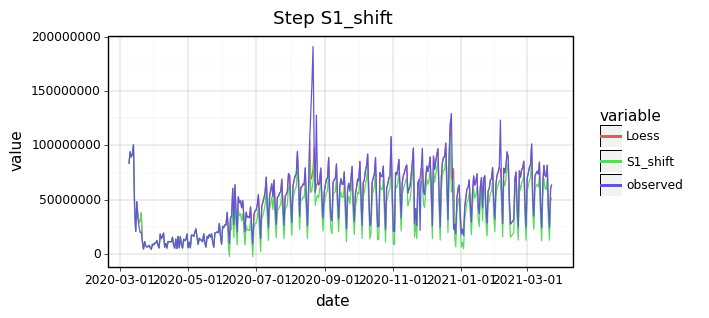

2021-03-24 12:13:31.673 | DEBUG    | __main__:_run_step:56 - ... step done ...
2021-03-24 12:13:31.676 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-24 12:13:31.677 | INFO     | __main__:_run_step:11 - Target variable: S1_shift 

2021-03-24 12:13:31.678 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-24 12:13:31.679 | DEBUG    | __main__:_validate_series:17 - ... validating S1_shift...

2021-03-24 12:13:31.775 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 11
2021-03-24 12:13:31.776 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-03-17 00:00:00'), Timestamp('2020-03-18 00:00:00'), Timestamp('2020-03-19 00:00:00'), Timestamp('2020-03-20 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-11-20 00:00:00'), Timestamp('2020-11-27 00:00:00'), Timestamp('2020-12-13 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2021-01-01 00:00:00')]
2021-03-24 12:13:31.77

<ggplot: (8745282660333)>


2021-03-24 12:13:32.436 | DEBUG    | __main__:_run_shift_grid:79 - Total combinations: 25
2021-03-24 12:13:32.729 | DEBUG    | __main__:_initial_shift_date:143 - Shift found at 2020-07-07 00:00:00
2021-03-24 12:13:32.733 | DEBUG    | __main__:_shift_ts:161 - 

2021-03-24 12:13:32.735 | DEBUG    | __main__:_shift_ts:162 - Center point: -11555176.428571437


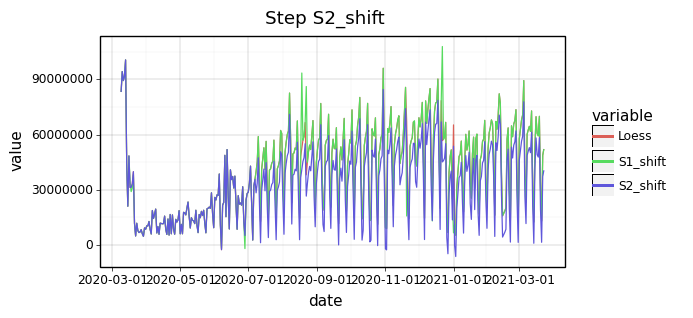

2021-03-24 12:13:33.130 | DEBUG    | __main__:_run_step:56 - ... step done ...


<ggplot: (8745283187893)>


2021-03-24 12:13:33.515 | DEBUG    | __main__:_write_missing:17 - ... writing anomalies file ...


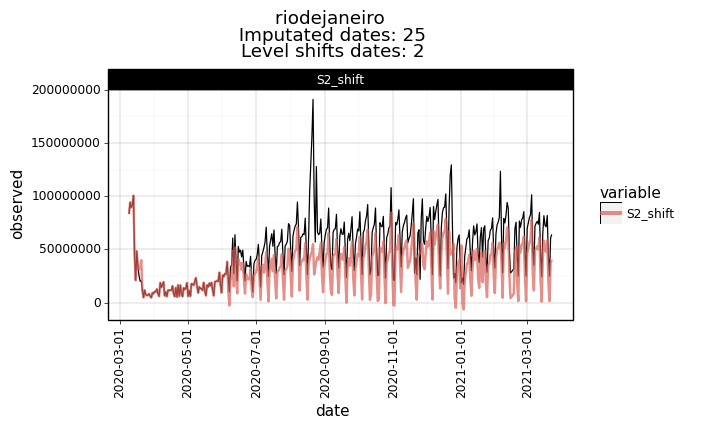

<ggplot: (8745282627101)>


/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_riodejaneiro.pdf
2021-03-24 12:13:35.402 | INFO     | __main__:_run_single:82 - ... riodejaneiro done ...



In [41]:
daily, weekly = _run_single(region_slug='riodejaneiro', 
                            anomaly_vote_minimun_s1=1, 
                            anomaly_vote_minimun_s2=1, 
                            print_report = False, 
                            print_plot = True)

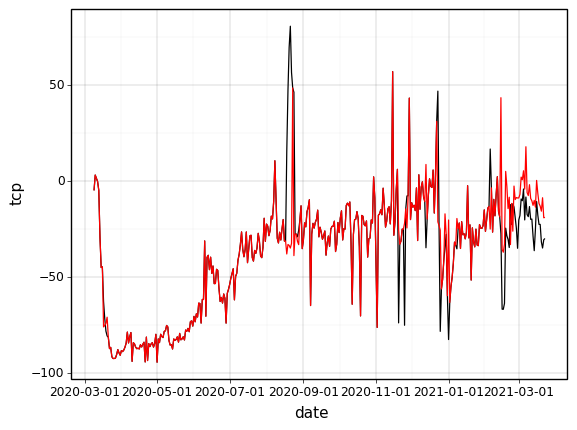

<ggplot: (8745283182677)>

In [35]:
daily.head(3)
(p9.ggplot(daily, p9.aes(x = 'date', y='tcp')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes( y='tcp_clean'), color = 'red'))

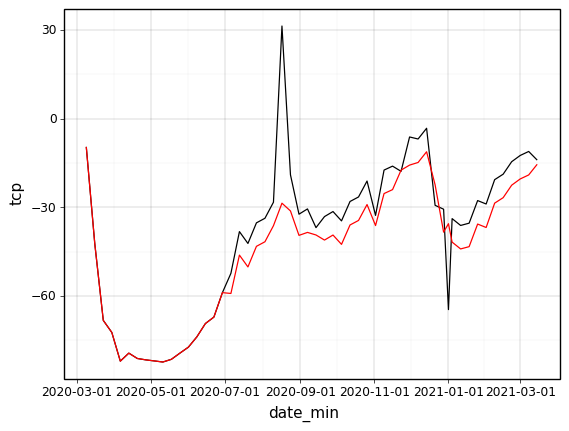

<ggplot: (8733732292905)>

In [294]:
weekly.head(3)
(p9.ggplot(weekly, p9.aes(x = 'date_min', y='tcp')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes( y='tcp_clean'), color = 'red'))

#### First run

In [43]:
region_slug = 'mexicocity'
df_cty = _reading_data(region_slug)
df_cty.head(3)

2021-03-21 14:57:33.043 | DEBUG    | __main__:_reading_data:10 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('mexicocity')
        


,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,year,month,day,dow,observed,expected_2020,ratio_20,tcp,dashboard,region_shapefile_wkt,date
0,2021-03-21 10:54:20.221,mexicocity,Ciudad de México,Mexico,MX,ME,city,22381714,America/Mexico_City,2021,2,26,5,185722147,226328826.0,0.820585,-17.941453,TRUE,Polygon ((-99.22541498771096258 19.79958548078...,2021-02-26
1,2021-03-21 10:54:20.221,mexicocity,Ciudad de México,Mexico,MX,ME,city,22381714,America/Mexico_City,2021,1,15,5,131577688,226328826.0,0.581356,-41.864370,TRUE,Polygon ((-99.22541498771096258 19.79958548078...,2021-01-15
2,2021-03-21 10:54:20.221,mexicocity,Ciudad de México,Mexico,MX,ME,city,22381714,America/Mexico_City,2020,10,9,5,137758578,226328826.0,0.608666,-39.133437,TRUE,Polygon ((-99.22541498771096258 19.79958548078...,2020-10-09


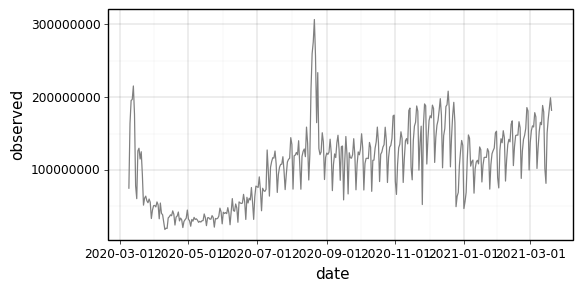

<ggplot: (8733763966757)>

In [16]:
gg=(p9.ggplot(data=df_cty.reset_index(),
           mapping=p9.aes(x='date', y='observed')) 
    + p9.geom_line(color = 'gray')
    + p9.theme(figure_size=(6, 3)))
gg

2021-03-21 14:51:15.996 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 14:51:15.997 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 14:51:15.997 | DEBUG    | __main__:_run_step:11 - Target variable: observed 

2021-03-21 14:51:15.998 | DEBUG    | __main__:_find_anomalies:100 - 
... finding outliers ...
2021-03-21 14:51:15.998 | DEBUG    | __main__:_validate_series:15 - ... validating observed...

2021-03-21 14:51:16.116 | DEBUG    | __main__:_find_anomalies:111 - Number of anomalies found: 16
2021-03-21 14:51:16.117 | DEBUG    | __main__:_find_anomalies:112 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-11-25 00:00:0

          date  anomaly_persist
0   2020-03-09              NaN
1   2020-03-10              NaN
2   2020-03-11              NaN
3   2020-03-12              NaN
4   2020-03-13              NaN
..         ...              ...
372 2021-03-16              0.0
373 2021-03-17              0.0
374 2021-03-18              0.0
375 2021-03-19              0.0
376 2021-03-20              0.0

[377 rows x 2 columns]
          date  anomaly_seasonal
0   2020-03-09             False
1   2020-03-10             False
2   2020-03-11             False
3   2020-03-12             False
4   2020-03-13             False
..         ...               ...
372 2021-03-16             False
373 2021-03-17             False
374 2021-03-18             False
375 2021-03-19             False
376 2021-03-20             False

[377 rows x 2 columns]
          date  anomaly_autor
0   2020-03-09            NaN
1   2020-03-10            NaN
2   2020-03-11            NaN
3   2020-03-12            NaN
4   2020-03-13        

/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/layer.py:464: PlotnineWarning: geom_point : Removed 361 rows containing missing values.


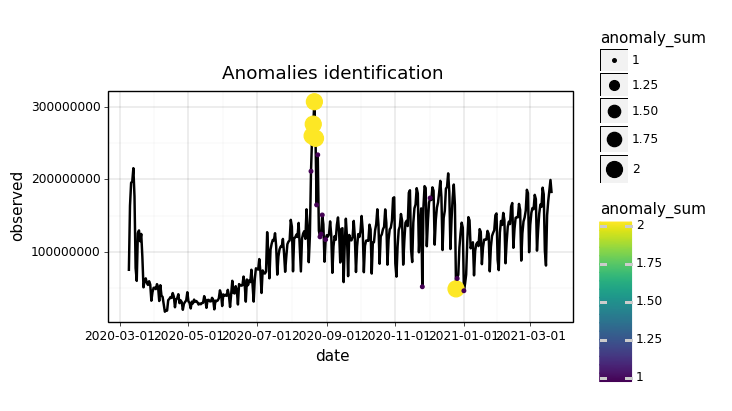

2021-03-21 14:51:16.581 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-03-21 14:51:16.619 | DEBUG    | __main__:_run_step:28 - Output variable S1_shift
2021-03-21 14:51:16.620 | DEBUG    | __main__:_shift_level:213 - 

2021-03-21 14:51:16.621 | DEBUG    | __main__:_shift_level:214 - ... shifting levels for Loess ...
2021-03-21 14:51:16.623 | DEBUG    | __main__:_validate_series:15 - ... validating Loess...

2021-03-21 14:51:16.629 | DEBUG    | __main__:_run_shift_grid:61 - 
... shift level running grid  ...


<ggplot: (8733764551777)>


2021-03-21 14:51:17.235 | DEBUG    | __main__:_run_shift_grid:79 - Total combinations: 25
2021-03-21 14:51:17.514 | DEBUG    | __main__:_initial_shift_date:143 - Shift found at 2020-07-06 00:00:00
2021-03-21 14:51:17.517 | DEBUG    | __main__:_shift_ts:161 - 

2021-03-21 14:51:17.517 | DEBUG    | __main__:_shift_ts:162 - Center point: -13806746.571428582
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/ipykernel_launcher.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/layer.py:464: PlotnineWarning: geom_point : Removed 9274 rows containing missing values.


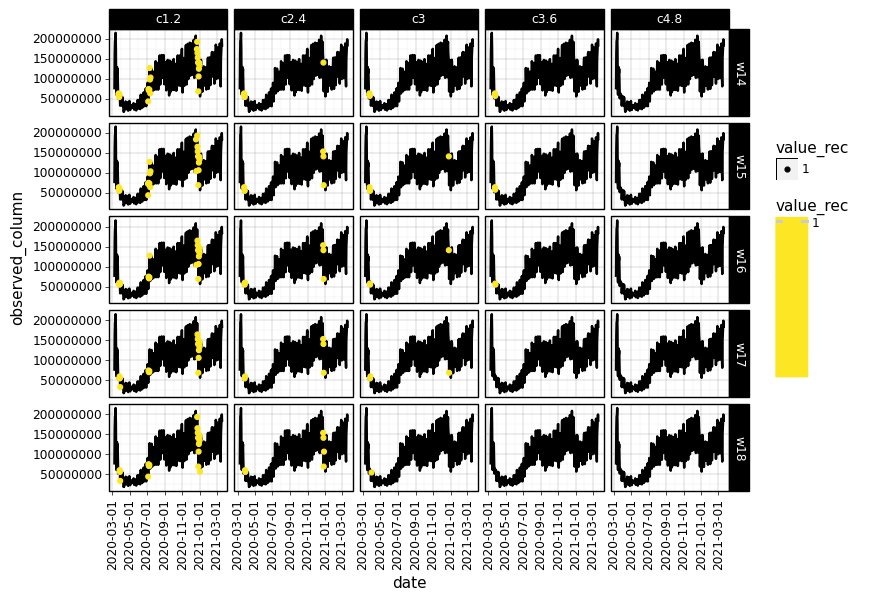

<ggplot: (8733764389113)>
Empty DataFrame
Columns: [date, shift_sum]
Index: []


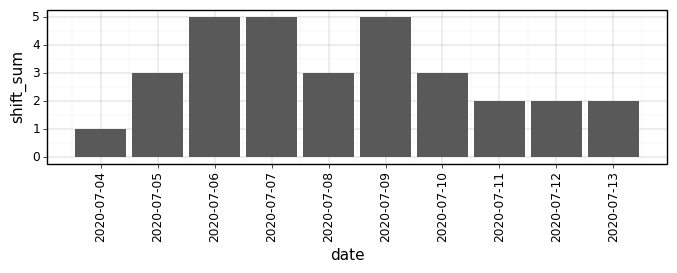

<ggplot: (8733764326905)>


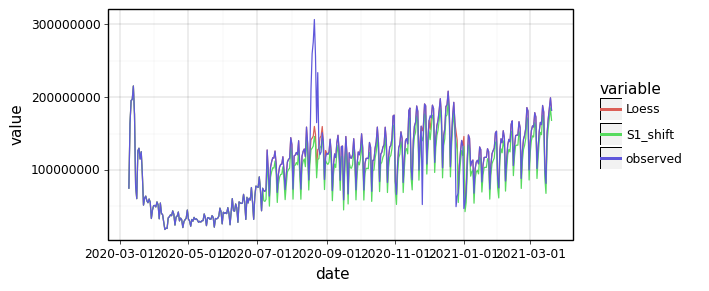

2021-03-21 14:51:30.680 | DEBUG    | __main__:_run_step:55 - ... step done ...


<ggplot: (8733753066445)>


In [17]:
df_run_1 = _run_step(df_run = df_cty.sort_values(by=['region_slug', 'date']),
                         anomaly_vote_minimun = 1, 
                         c_param=_c_param(region_slug),
                         target_column_name = 'observed',
                         output_column_name = 'S1_shift',
                         print_report = True, 
                         print_plot = True)

In [82]:
df_run_1.head()

,date,observed,Loess,S1_shift,outliers,level_shifts
0,2020-03-09,74001430,74001430,74001430.0,False,False
1,2020-03-10,163743625,163743625,163743625.0,False,False
2,2020-03-11,195417551,195417551,195417551.0,False,False
3,2020-03-12,196938136,196938136,196938136.0,False,False
4,2020-03-13,215453447,215453447,215453447.0,False,False


#### Second run

2021-03-21 15:02:35.560 | DEBUG    | __main__:_c_param:15 - c_param: 3
2021-03-21 15:02:35.560 | DEBUG    | __main__:_run_step:10 - ... step start ...
2021-03-21 15:02:35.561 | DEBUG    | __main__:_run_step:11 - Target variable: S1_shift 

2021-03-21 15:02:35.562 | DEBUG    | __main__:_find_anomalies:95 - 
... finding outliers ...
2021-03-21 15:02:35.563 | DEBUG    | __main__:_validate_series:15 - ... validating S1_shift...

2021-03-21 15:02:35.662 | DEBUG    | __main__:_find_anomalies:106 - Number of anomalies found: 5
2021-03-21 15:02:35.663 | DEBUG    | __main__:_find_anomalies:107 - [Timestamp('2020-09-16 00:00:00'), Timestamp('2020-11-02 00:00:00'), Timestamp('2020-12-30 00:00:00'), Timestamp('2021-01-02 00:00:00'), Timestamp('2021-03-15 00:00:00')]
2021-03-21 15:02:35.665 | DEBUG    | __main__:_impute_anomalies:38 - 
... imputing outliers ...
2021-03-21 15:02:35.700 | DEBUG    | __main__:_run_step:28 - Output variable S2_shift
2021-03-21 15:02:35.701 | DEBUG    | __main__:_shift_

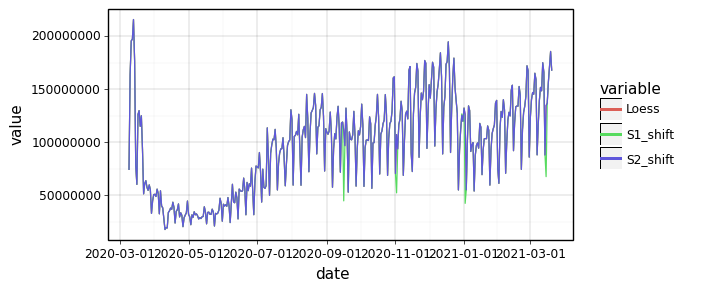

2021-03-21 15:02:37.125 | DEBUG    | __main__:_run_step:55 - ... step done ...


<ggplot: (8733751407213)>


In [58]:
df_run_2 = _run_step(df_run = df_run_1[['date', 'S1_shift']].sort_values(by=['date']),
                         anomaly_vote_minimun = 1, 
                         c_param=_c_param(region_slug),
                         target_column_name = 'S1_shift',
                         output_column_name = 'S2_shift',
                         print_report = False, 
                         print_plot = True)

In [221]:
qry = """
select 
    *
from spd_sdv_waze_corona.prod_daily_weekly_index
limit 10
"""
df = pd.read_sql_query(qry, conn)

In [226]:
df.columns #sort_values('week_number')

Index(['last_updated_utc', 'region_slug', 'region_name', 'country_name',
       'country_iso_code', 'country_idb_code', 'region_type', 'population',
       'timezone', 'week_number', 'min_year', 'min_month', 'min_day',
       'max_month', 'max_day', 'observed', 'expected_2020', 'ratio_20', 'tcp',
       'dashboard', 'region_shapefile_wkt'],
      dtype='object')